In [5]:
from gensim.models import Word2Vec 
from collections import defaultdict
from sklearn.metrics import jaccard_score
import numpy as np


In [6]:
# Load the pre-trained Word2Vec model
model_dict = {'phase_1': Word2Vec.load('../model/word2vec_model_phase_1.model'),
              'phase_2': Word2Vec.load('../model/word2vec_model_phase_2.model'),
              'phase_3': Word2Vec.load('../model/word2vec_model_phase_3.model')}

# Define keywords and number of nearest neighbors
keywords = ['swaraj', 'independence', 'crown', 'imperial']
top_n = 100

# Collect nearest neighbors for each keyword per phase
neighbors = defaultdict(dict)

for phase, model in model_dict.items():
    for word in keywords:
        if word in model.wv.key_to_index:
            similar_words = [w for w, _ in model.wv.most_similar(word, topn=top_n)]
            neighbors[word][phase] = set(similar_words)
        else:
            print(f"'{word}' not in vocabulary for {phase}.")

# Compute Jaccard similarities between consecutive phases
jaccard_results = defaultdict(dict)

for word in keywords:
    phases = list(model_dict.keys())
    for i in range(len(phases) - 1):
        p1, p2 = phases[i], phases[i + 1]
        set1, set2 = neighbors[word].get(p1, set()), neighbors[word].get(p2, set())
        if set1 and set2:
            intersection = len(set1 & set2)
            union = len(set1 | set2)
            print(f"Word: {word}, Phase: {p1} and {p2}, Intersection: {intersection}, Union: {union}")
            jaccard_sim = intersection / union
            jaccard_results[word][f"{p1}_vs_{p2}"] = jaccard_sim
        else:
            jaccard_results[word][f"{p1}_vs_{p2}"] = None

# Print results
for word, results in jaccard_results.items():
    print(f"\nKeyword: '{word}'")
    for pair, score in results.items():
        print(f"{pair}: {score:.3f}" if score is not None else f"{pair}: N/A")



Word: swaraj, Phase: phase_1 and phase_2, Intersection: 5, Union: 195
Word: swaraj, Phase: phase_2 and phase_3, Intersection: 16, Union: 184
Word: independence, Phase: phase_1 and phase_2, Intersection: 3, Union: 197
Word: independence, Phase: phase_2 and phase_3, Intersection: 7, Union: 193
Word: crown, Phase: phase_1 and phase_2, Intersection: 1, Union: 199
Word: crown, Phase: phase_2 and phase_3, Intersection: 0, Union: 200
Word: imperial, Phase: phase_1 and phase_2, Intersection: 0, Union: 200
Word: imperial, Phase: phase_2 and phase_3, Intersection: 0, Union: 200

Keyword: 'swaraj'
phase_1_vs_phase_2: 0.026
phase_2_vs_phase_3: 0.087

Keyword: 'independence'
phase_1_vs_phase_2: 0.015
phase_2_vs_phase_3: 0.036

Keyword: 'crown'
phase_1_vs_phase_2: 0.005
phase_2_vs_phase_3: 0.000

Keyword: 'imperial'
phase_1_vs_phase_2: 0.000
phase_2_vs_phase_3: 0.000


In [14]:
import umap
import matplotlib.pyplot as plt
from adjustText import adjust_text

/Users/dushyantgoel/miniconda3/envs/nlp/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/dushyantgoel/miniconda3/envs/nlp/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


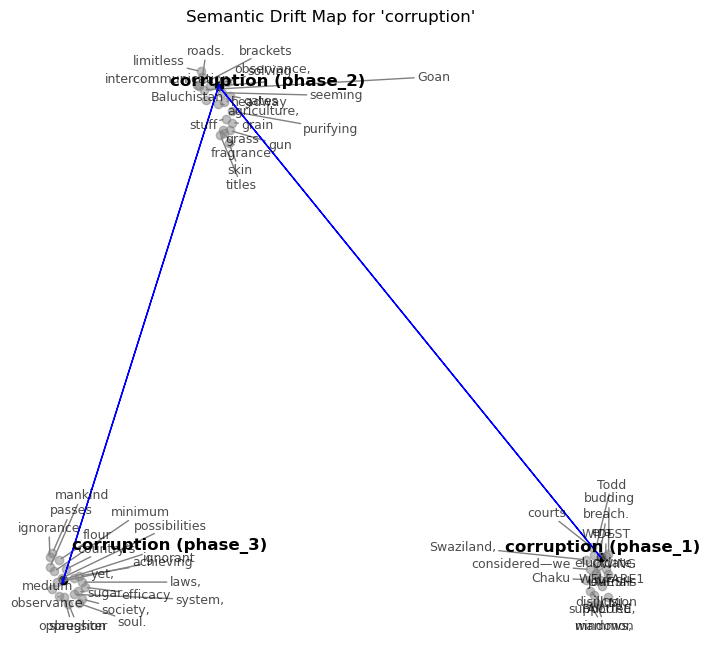

In [ ]:
# Set target word and neighbors
target_word = 'swaraj'
top_n = 20

# Collect embeddings
all_words = []
embeddings = []
labels = []
positions = {}
texts = []

for phase, model in model_dict.items():
    if target_word in model.wv:
        # Get neighbors + target word
        neighbors = [w for w, _ in model.wv.most_similar(target_word, topn=top_n)]
        words = [target_word] + neighbors
        
        # Store vectors
        vecs = [model.wv[w] for w in words]
        embeddings.extend(vecs)
        labels.extend([f"{w} ({phase})" if w == target_word else w for w in words])
        all_words.extend(words)
        positions[phase] = len(embeddings) - len(words)  # track index of target word

# Dimensionality reduction
reducer = umap.UMAP(random_state=42)
embedding_2d = reducer.fit_transform(embeddings)

# Plot
plt.figure(figsize=(8, 8))

for i, (x, y) in enumerate(embedding_2d):
    if target_word in labels[i]:
        plt.scatter(x, y, c='black')
        texts.append(plt.text(x, y, labels[i], fontsize=12, weight='bold'))
    else:
        plt.scatter(x, y, c='grey', alpha=0.5)
        texts.append(plt.text(x, y, labels[i], fontsize=9, alpha=0.7))

# Adjust text labels to avoid overlap
adjust_text(texts, arrowprops=dict(arrowstyle='-', color='grey'))


# Draw arrows between target word positions
phases = list(model_dict.keys())
for i in range(len(phases) - 1):
    idx1 = positions[phases[i]]
    idx2 = positions[phases[i + 1]]
    plt.arrow(
        embedding_2d[idx1][0], embedding_2d[idx1][1],
        embedding_2d[idx2][0] - embedding_2d[idx1][0],
        embedding_2d[idx2][1] - embedding_2d[idx1][1],
        head_width=0.1, head_length=0.15, fc='blue', ec='blue'
    )

plt.title(f"Semantic Drift Map for '{target_word}'")
plt.axis('off')
plt.show()



In [6]:
# from sklearn.manifold import TSNE
# import matplotlib.pyplot as plt


# def tsne_plot(model, words, label):
#     word_vectors = [model.wv[word] for word in words if word in model.wv]
#     tsne = TSNE(n_components=2, random_state=0, perplexity=30)
#     Y = tsne.fit_transform(np.array(word_vectors))

#     plt.figure(figsize=(10, 8))
#     plt.scatter(Y[:, 0], Y[:, 1])
#     for i, word in enumerate(words):
#         plt.annotate(word, xy=(Y[i, 0], Y[i, 1]))
#     plt.title(label)
#     plt.show()


# for phase, model_path in model_dict.items():
#     # Load the model
#     model = Word2Vec.load(model_path)
#     tsne_plot(model, vocab[:100], "Word2Vec Phase 1")

In [25]:
# for phase, model in model_dict.items():

#     print(f"Phase: {phase}, model: {model}")

#     # Find the most similar words to keyword list
#     keywords = ['corruption', 'British']

#     print(f"\nMost similar words to keywords in {phase}:")
    
#     # Find the most similar words to the keywords
#     similar_words = []
#     for keyword in keywords:
#         try:
#             similar = model.wv.most_similar(keyword, topn=10)
#             similar_words.append((keyword, similar))
#             print(f"  Most similar words to '{keyword}':")
#             for word, similarity in similar:
#                 print(f"    {word}: {similarity:.4f}")
#         except KeyError:
#             print(f"Keyword '{keyword}' not found in the model vocabulary.")

In [5]:
# Take user input for a word
# word = input("Enter a word to find its vector representation: ")

# # Get the vector representation of the word
# try:
#     word_vector = model.wv[word]
#     print(f"Vector representation of '{word}': {word_vector}")
#     # Find the most similar words to input"
#     similar_words = model.wv.most_similar(word, topn=10)
# except KeyError:
#     print(f"'{word}' not found in the vocabulary.")


In [7]:
# from sklearn.manifold import TSNE
# import matplotlib.pyplot as plt

# def tsne_plot(model, words, label):
#     word_vectors = [model.wv[word] for word in words if word in model.wv]
#     tsne = TSNE(n_components=2, random_state=0, perplexity=30)
#     Y = tsne.fit_transform(word_vectors)
    
#     plt.figure(figsize=(10, 8))
#     plt.scatter(Y[:, 0], Y[:, 1])
#     for i, word in enumerate(words):
#         plt.annotate(word, xy=(Y[i, 0], Y[i, 1]))
#     plt.title(label)
#     plt.show()
